# 0. Setup

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ipyplot
from IPython.display import clear_output

url_pattern = "http://images.amazon.com/images/P/ASIN.01._SCLZZZZZZZ_.jpg"

MAX_IMAGES = 10
MAX_IMAGES_REC = 40
IMG_WIDTH = 150


Working directory:
/content/sansa

Directory contents:
datasets    experiments  LICENSE  NOTICE      README.md  sparseinv
evaluation  __init__.py  models   poster.pdf  sansa.png


# 1. Dataset

Downloaded Amazon Books dataset.
Dataset info:
{'Dataset name': 'amazonbook', 'Number of users': 52643, 'Number of items': 91599, 'Number of interactions': 2984108, 'Interaction density': '0.0619%'}

Item distribution
count    91599.000000
mean        32.577954
std         45.273947
min         10.000000
25%         13.000000
50%         19.000000
75%         35.000000
95%         94.000000
99.9%      551.000000
max       1907.000000
Name: item_id, dtype: float64


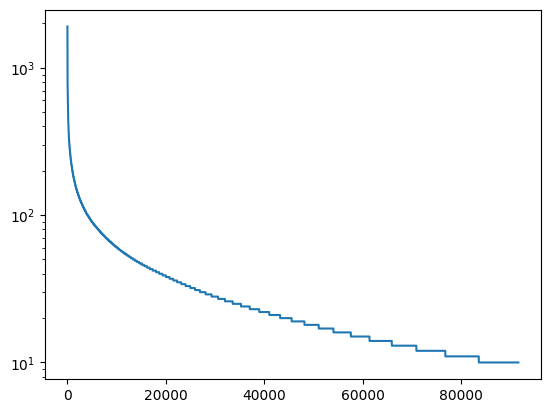


User distribution
count    52643.000000
mean        56.685751
std         96.863097
min         16.000000
25%         24.000000
50%         33.000000
75%         57.000000
95%        165.000000
99.9%      837.000000
max      13313.000000
Name: user_id, dtype: float64


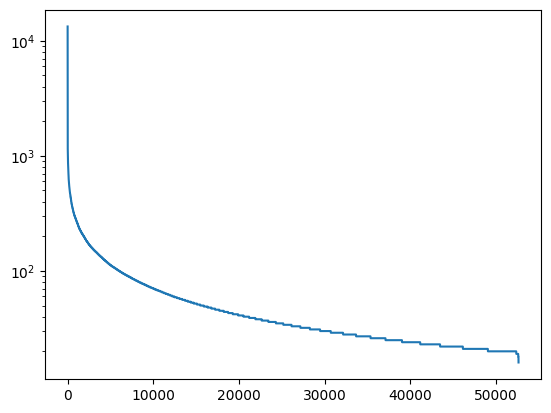


Creating dataset splits...


INFO:evaluation.logs:Dataframe lengths | train_df: 2380730, val_df: 2380730, test_df: 2984108
INFO:evaluation.logs:Removing users [50736, 52234, 41589, 13647] from test inputs.
INFO:evaluation.logs:Splits information:
INFO:evaluation.logs:Train split info | n_users = 52643, n_items = 91599, n_ratings = 2380730, sparsity = 99.95%
INFO:evaluation.logs:Validation split info | n_users = 52643, n_items = 91599, n_ratings = 2380730, sparsity = 99.95%
INFO:evaluation.logs:Test split info | n_users = 52639, n_items = 91599, n_ratings = 2380661, sparsity = 99.95%
INFO:evaluation.logs:Execution of create_splits took at 114.937 seconds.


Done.


In [ ]:
# 1.1. create folder inside `datasets`
dataset_path = "datasets/data/amazonbook"
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

# 1.2. download Amazon Book dataset (https://github.com/kuandeng/LightGCN/tree/master/Data/amazon-book)
os.chdir("/".join([project_root, dataset_path]))
!wget https://raw.githubusercontent.com/kuandeng/LightGCN/master/Data/amazon-book/item_list.txt
!wget https://raw.githubusercontent.com/kuandeng/LightGCN/master/Data/amazon-book/test.txt
!wget https://raw.githubusercontent.com/kuandeng/LightGCN/master/Data/amazon-book/train.txt
!wget https://raw.githubusercontent.com/kuandeng/LightGCN/master/Data/amazon-book/user_list.txt
!ls
os.chdir(project_root)

# 1.3. create Dataset object from the downloaded data.
# we will create an instance of AmazonBook Dataset (see `datasets/amazonbook.py`)
# for examples on how to create your own Dataset subclass, see `datasets/dataset.py` and other modules in `datasets`
# (implementation depends on 1. input data format, 2. preprocessing, 3. train-val-test split protocol)
from datasets.amazonbook import Amazonbook
dataset_config = {
    "name": "amazonbook",
    "rewrite": False,
}
dataset = Amazonbook.from_config(dataset_config)

clear_output()
print("Downloaded Amazon Books dataset.")
print("Dataset info:")
print(dataset.info())
print()

# 1.4. dataset statistics
# item_id histogram
item_id_counts = dataset.dataset.item_id.value_counts()
print("Item distribution")
print(item_id_counts.describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.999]))
fig1 = plt.semilogy(np.arange(len(item_id_counts)), item_id_counts.values)
plt.show()
print()
# user_id histogram
user_id_counts = dataset.dataset.user_id.value_counts()
print("User distribution")
print(user_id_counts.describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.999]))
fig2 = plt.semilogy(np.arange(len(user_id_counts)), user_id_counts.values)
plt.show()
print()

# 1.5. create dataset splits
# specify split configuration
split_config = {
    "seed": 42,
    "val_target_proportion": 0.0,
}

# create train, val, test sets
print("Creating dataset splits...")
(train, val, test), _ = dataset.create_splits(config=split_config)  # also transforms original item_ids to range(0,num_items)
print("Done.")

# 1.6. create ASIN <--> item_id mapping (to make this demo pretty :) )
np.testing.assert_array_equal(np.arange(91599), train.item_encoder.classes_)  # we won't need to map original item_ids <--> encoded item_ids
def get_asin_to_item_dicts(item_list_path):
    with open(item_list_path, "r") as f:
        lines = f.readlines()[1:]
    asin2item, item2asin = {}, {}
    for line in lines:
        a, i = tuple(line.strip().split(" "))
        if (a != "") and (i != ""):
          asin2item[a] = int(i)
          item2asin[int(i)] = a

    return asin2item, item2asin

item_list_path = dataset_path + "/item_list.txt"
asin2item, item2asin = get_asin_to_item_dicts(item_list_path)

# 2. Model training

In [ ]:
# import model
from models.sansa import SANSA

# create model instance from config
model_config = {
    "l2": 20.0,  # L2 regularization
    "target_density": 1e-4,  # num_nonzeros / (num_items)^2 = 0.005%
    "ainv_params": {
        "umr_scans": 3,  # number of refinement passes through entire matrix. later scans are more precise and expensive. 0-3 recommended
        "umr_finetune_steps": 10,  # number of refinements improving "several worst columns". relatively inexpensive. typically 0-20
        "umr_loss_threshold": 1e-4,  # if loss reaches below threshold, training is finished
    },
    "ldlt_method": "icf",  # also available "cholmod" -- more accurate & more expensive (cholmod is exact factorization + sparsification, icf is incomplete factorization)
}

model = SANSA.from_config(model_config)

model.train(train_split=train)

INFO:evaluation.logs:Train user-item matrix info | n_users = 52643, n_items = 91599, n_ratings = 2380730, sparsity = 99.95%
INFO:evaluation.logs:Item-item matrix info | shape = (91599,91599)
INFO:evaluation.logs:Training SANSA with L2=20.0, target density=0.010000%, LDL^T method=icf, approx. inverse method=umr...
INFO:evaluation.logs:Loading item-user matrix...
INFO:evaluation.logs:Constructing weights:
INFO:evaluation.logs:Constructing A...
INFO:evaluation.logs:A info | nnz: 330335853, size: 3964.4 MB
INFO:evaluation.logs:Computing incomplete LL^T decomposition...
INFO:evaluation.logs:L info | nnz: 839003, size: 10.434 MB, density: 0.010000%
INFO:evaluation.logs:Scaling columns and creating D (LL^T -> L'DL'^T)
INFO:evaluation.logs:Execution of ldlt took at 98.850 seconds.
INFO:evaluation.logs:nnz of L: 839003, size: 10.434 MB
INFO:evaluation.logs:Computing approximate inverse of L:
INFO:evaluation.logs:Calculating initial guess using 1 step of Schultz method...
INFO:evaluation.logs:Ca

# 3. Evaluation

In [ ]:
# Accuracy-based recommendation quality metrics
def recall(ids_true: np.ndarray, ids_top_k: np.ndarray) -> float:
    k = len(ids_top_k)
    num_true = len(ids_true)
    num_positive = np.sum(np.isin(ids_top_k, ids_true), dtype=np.float32)
    return num_positive / min(k, num_true)


# recall used by openbenchmark BARS
def recall_BARS(ids_true: np.ndarray, ids_top_k: np.ndarray) -> float:
    num_true = len(ids_true)
    num_positive = np.sum(np.isin(ids_top_k, ids_true), dtype=np.float32)
    return num_positive / num_true


def ndcg(ids_true, ids_top_k) -> float:
    k = len(ids_top_k)
    num_true = len(ids_true)
    relevances_top_k = np.isin(ids_top_k, ids_true).astype(np.float32)
    with np.errstate(
        divide="ignore"
    ):  # can raise divide by zero warning when using intel MKL numpy. Most likely cause by endianness
        tp = 1.0 / np.log2(np.arange(2, k + 2))
    dcg = (relevances_top_k * tp).sum()
    idcg = tp[: min(num_true, k)].sum()
    return dcg / idcg

def get_stats(metrics: list[float]) -> dict:
    """
    Summary statistics of a list of metrics.
    """
    stats = {
        "mean": np.average(metrics),
        "se": np.std(metrics) / np.sqrt(len(metrics)),
    }
    return stats


def evaluate(
    model: Model,
    split: DatasetSplit,
    metrics: list[str] = ["recall", "ndcg"],
    ks: list[int] = [20, 50, 100],
    batch_size: int = 2000,
) -> dict[int : dict[str:dict]]:
    """
    Batched evaluation of a model on a split of a dataset.
    """
    stats = {
        k: {
            "coverage": 0.0,
        }
        for k in ks
    }
    max_k = max(ks)

    total_users = len(split.user_encoder.classes_)

    recalls = {k: [] for k in ks}
    recalls_BARS = {k: [] for k in ks}
    ndcgs = {k: [] for k in ks}

    for batch_start in range(0, total_users, batch_size):
        if batch_start + batch_size > total_users:
            batch_end = total_users
        else:
            batch_end = batch_start + batch_size
        print(f"Evaluating model at batch {batch_start}:{batch_end}")
        batch_users = list(split.user_encoder.classes_)[batch_start:batch_end]
        batch_data = split.get_rated_items(batch_users)
        batch_targets = split.get_target_items(batch_users)
        batch_target_ids_dict = (
            batch_targets.groupby("user_id", group_keys=True)["item_id"]
            .apply(list)
            .to_dict()
        )
        batch_keys = list(batch_target_ids_dict.keys())
        users_to_arange = {user: i for i, user in enumerate(batch_keys)}
        pd.options.mode.chained_assignment = None  # suppress irrelevant warning
        batch_data["user_id"] = batch_data["user_id"].map(users_to_arange)
        pd.options.mode.chained_assignment = "warn"
        batch_top_maxk_ids, batch_top_maxk_scores = model.recommend(batch_data, k=max_k)

        for k in ks:
            recalls_batch = []
            recalls_BARS_batch = []
            ndcgs_batch = []

            for i in range(len(batch_users)):
                target_ids = batch_target_ids_dict[batch_keys[i]]
                top_k_ids = batch_top_maxk_ids[i, :k]
                recalls_batch.append(recall(target_ids, top_k_ids))
                recalls_BARS_batch.append(recall_BARS(target_ids, top_k_ids))
                ndcgs_batch.append(ndcg(target_ids, top_k_ids))

            recalls[k] += recalls_batch
            recalls_BARS[k] += recalls_BARS_batch
            ndcgs[k] += ndcgs_batch

    for k in ks:
        if "recall" in metrics:
            stats[k]["recall"] = get_stats(metrics=recalls[k])
        if "recall BARS" in metrics:
            stats[k]["recall BARS"] = get_stats(metrics=recalls_BARS[k])
        if "ndcg" in metrics:
            stats[k]["ndcg"] = get_stats(metrics=ndcgs[k])

    return stats

In [ ]:
metrics = ["recall BARS", "ndcg"]
ks = [20, 40]
batch_size = 2000

evaluation_dict = evaluate(model=model,
        split=test,
        metrics = metrics,
        ks = ks,
        batch_size = batch_size,
)

clear_output()
print(f"Recall @ 20: {evaluation_dict[20]['recall']['mean']:.5f} +- {evaluation_dict[20]['recall']['se']:.5f}")
print(f"Recall @ 40: {evaluation_dict[40]['recall']['mean']:.5f} +- {evaluation_dict[40]['recall']['se']:.5f}")
print(f"nDCG @ 20: {evaluation_dict[20]['ndcg']['mean']:.5f} +- {evaluation_dict[20]['ndcg']['se']:.5f}")
print(f"nDCG @ 40: {evaluation_dict[40]['ndcg']['mean']:.5f} +- {evaluation_dict[40]['ndcg']['se']:.5f}")

Recall @ 20: 0.07844 +- 0.00059
Recall @ 40: 0.11305 +- 0.00071
nDCG @ 20: 0.06238 +- 0.00050
nDCG @ 40: 0.07616 +- 0.00053


# 4. Inference demo

In [ ]:
np.random.seed(42)

## 4.0. "Sanity check" - Recommending for a user with mainstream taste

### Interactions

In [ ]:
sample_user_id = 7  # Terry Pratcher, Steven King, Philip Pullman

# user's interactions
interaction_df = test.data[test.data.user_id == sample_user_id]
# translate item_ids to ASINS
interacted_item_ids, interacted_feedback = interaction_df.item_id.values, interaction_df.feedback.values
interacted_asins = np.vectorize(item2asin.get)(interacted_item_ids)

print("Interacted book ASINs")
print(interacted_asins)

# display sample of interactions
urls = []
asins = np.random.choice(interacted_asins, size=MAX_IMAGES, replace=False)
print("Sample interactions")
ipyplot.plot_images(
    [url_pattern.replace("ASIN", asin) for asin in asins],
    labels=asins,
    img_width=IMG_WIDTH
)

Interacted book ASINs
['0689110456' '039913297X' '0345311965' '067101675X' '0061091995'
 '0061020699' '0061020672' '0740704818' '0451167538' '0061020702'
 '0307743667' '0451161343' '0679643524' '067155302X' '0425194523'
 '0345413369' '0345413350' '0446600660' '0345338588']
Sample interactions


### Predictions


In [ ]:
# run prediction for the user
k = 20

top_k_item_ids, top_k_scores = model.recommend(inputs=(interacted_item_ids, interacted_feedback), k=k)
top_k_item_ids, top_k_scores = top_k_item_ids.reshape(-1), top_k_scores.reshape(-1)
top_k_scores /= np.linalg.norm(top_k_scores)  # normalize score vector to unit length (optional)
# translate predicted item_ids to ASINS
top_k_asins = np.vectorize(item2asin.get)(top_k_item_ids)

# display predicted items
urls = []
asins = top_k_asins[:MAX_IMAGES_REC]
print()
print("Recommendations")
ipyplot.plot_images(
    [url_pattern.replace("ASIN", asin) for asin in asins],
    labels=[f"id: {i}, score: {s}" for i, s in list(zip(asins, top_k_scores))],
    img_width=IMG_WIDTH
)

INFO:evaluation.logs:Execution of _matmat took at 0.001 seconds.
INFO:evaluation.logs:Execution of _matmat took at 0.001 seconds.
INFO:evaluation.logs:Execution of _predict took at 0.009 seconds.



Recommendations


### Target items

In [ ]:
# translate target item_ids to ASINS
target_item_ids = test.targets[test.targets.user_id == sample_user_id].item_id.values
target_asins = np.vectorize(item2asin.get)(target_item_ids)

# display target items
urls = []
asins = target_asins[:MAX_IMAGES]
print("Target items")
ipyplot.plot_images(
    [url_pattern.replace("ASIN", asin) for asin in asins],
    labels=asins,
    img_width=IMG_WIDTH
)

Target items


## 4.1. Recommending for a user with small number of interactions

### Interactions

In [ ]:
sample_user_id = 12430
test_user_id = test.user_encoder.transform([sample_user_id])[0]

# user's interactions
interaction_df = test.data[test.data.user_id == test_user_id]
print(f"Number of interactions: {len(interaction_df)}")
print()

# translate item_ids to ASINS
interacted_item_ids, interacted_feedback = interaction_df.item_id.values, interaction_df.feedback.values
interacted_asins = np.vectorize(item2asin.get)(interacted_item_ids)

print("Interacted book ASINs")
print(interacted_asins)

# display sample of interactions
print("Sample interactions")
urls = []
asins = np.random.choice(interacted_asins, size=MAX_IMAGES, replace=False)
ipyplot.plot_images(
    [url_pattern.replace("ASIN", asin) for asin in asins],
    labels=asins,
    img_width=IMG_WIDTH
)

Number of interactions: 16

Interacted book ASINs
['B00JNHU0T2' 'B00L8COOZG' 'B00KVU9LRW' 'B00L2F5P02' 'B00JCB8VRM'
 '0375856994' '0061132381' 'B00K4EGDSU' 'B00JIIUNUC' 'B00K9UXWMY'
 'B00I8A57CA' 'B00KEFZQ14' 'B00LE4Q370' 'B00JY0OTQ8' 'B00K9PHKPE'
 'B00JL4G1L8']
Sample interactions


### Predictions

In [ ]:
# run prediction for the user
k = 20

top_k_item_ids, top_k_scores = model.recommend(inputs=(interacted_item_ids, interacted_feedback), k=k)
top_k_item_ids, top_k_scores = top_k_item_ids.reshape(-1), top_k_scores.reshape(-1)
top_k_scores /= np.linalg.norm(top_k_scores)
# translate predicted item_ids to ASINS
top_k_asins = np.vectorize(item2asin.get)(top_k_item_ids)

# display predicted items
urls = []
asins = top_k_asins[:MAX_IMAGES_REC]
print()
print("Recommendations")
ipyplot.plot_images(
    [url_pattern.replace("ASIN", asin) for asin in asins],
    labels=[f"id: {i}, score: {s}" for i, s in list(zip(asins, top_k_scores))],
    img_width=IMG_WIDTH
)

INFO:evaluation.logs:Execution of _matmat took at 0.001 seconds.
INFO:evaluation.logs:Execution of _matmat took at 0.001 seconds.
INFO:evaluation.logs:Execution of _predict took at 0.006 seconds.



Recommendations


### Target items

In [ ]:
# translate target item_ids to ASINS
target_item_ids = test.targets[test.targets.user_id == test_user_id].item_id.values
target_asins = np.vectorize(item2asin.get)(target_item_ids)

# display target items
urls = []
asins = target_asins[:MAX_IMAGES]
print("Target items")
ipyplot.plot_images(
    [url_pattern.replace("ASIN", asin) for asin in asins],
    labels=asins,
    img_width=IMG_WIDTH
)

Target items


## 4.2. Recommending based on a single long-tail item

### Interaction

In [ ]:
# sample a long-tail item
sample_item_id = np.random.choice(item_id_counts[-1000:].index.values)
sample_asin = item2asin[sample_item_id]
print("Sample long-tail item")
print(f"item_id: {sample_item_id}")
print(f"ASIN: {sample_asin}")
print(f"number of interactions: {item_id_counts[sample_item_id]}")
ipyplot.plot_images([url_pattern.replace("ASIN", sample_asin)], labels=[sample_asin], img_width=IMG_WIDTH)

# create input tuple of np.arrays
sample_item, sample_feedback = np.array([sample_item_id]), np.array([1.])

Sample long-tail item
item_id: 8983
ASIN: 0199735603
number of interactions: 10


### Predictions

In [ ]:
# predict based on this item
k = 20

top_k_item_ids, top_k_scores = model.recommend(inputs=(sample_item, sample_feedback), k=k)
top_k_item_ids, top_k_scores = top_k_item_ids.reshape(-1), top_k_scores.reshape(-1)
top_k_scores /= np.linalg.norm(top_k_scores)
# translate predicted item_ids to ASINS
top_k_asins = np.vectorize(item2asin.get)(top_k_item_ids)

# display predicted items
urls = []
asins = top_k_asins[:MAX_IMAGES_REC]
print("Recommendations")
ipyplot.plot_images(
    [url_pattern.replace("ASIN", asin) for asin in asins],
    labels=[f"id: {i}, score: {s}" for i, s in list(zip(asins, top_k_scores))],
    img_width=IMG_WIDTH
)

INFO:evaluation.logs:Execution of _matmat took at 0.001 seconds.
INFO:evaluation.logs:Execution of _matmat took at 0.001 seconds.
INFO:evaluation.logs:Execution of _predict took at 0.007 seconds.


Recommendations
